# **Training the Diamond Price Prediction Model**

### ***Introduction:***

In this notebook we will go through the process of preprocessing the dataset, train a Deep Neural Network from scratch to predict diamonds prices, and evaluate model's performance.

### ***1. Importing Libraries and Modules:***

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append('../src')
sys.path.append('../data')

from model_training import DiamondPricePredictor
from data_processing import DataProcessor

### ***2. Data Preprocessing:***

In [17]:
data = DataProcessor(
    file_path='../data/raw/diamonds.csv',
    output_dir='../data/processed',
    selected_columns=['carat', 'x', 'y', 'z', 'price'],
    target_column='price',
    feature_columns=['carat', 'x', 'y', 'z'],
    )


We selected `carat`, `x`, `y`, and `z` as features based on their positive correlations with price, observed during the EDA phase.

In [18]:
save_path = '../data/processed/diamonds_processed.csv'
save_train_path = '../data/processed/diamonds_train.csv'
save_test_path = '../data/processed/diamonds_test.csv'

data.process_data(save_path=save_path, save_train_path=save_train_path, save_test_path=save_test_path)

Loading data...
Data loaded successfully.
Data shape: (53940, 5)
Missing values handled successfully.
Features normalized successfully.
Data split into training and testing sets successfully.
x_train shape: (42004, 4), y_train shape: (42004,)
x_test shape: (10502, 4), y_test shape: (10502,)


Split the dataset into training and test sets to ensure model generalization.

### ***3. Creating Model Object:***

In [35]:
model = DiamondPricePredictor(
    input_dim=4,
    output_dim=1,
    hidden_layer_sizes=[8, 4],
    learning_rate=0.001
)

`input_dim` corresponds to 4 features (`carat`, `x`, `y`, `z`), and `output_dim` corresponds to 1 target variable (`price`)

The neural network architecture includes **two hidden layers** with decreasing neuron sizes (`8 -> 4`) to capture complex relationships while avoiding overfitting.

A small **learning rate** (`0.001`) ensures gradual convergence of the optimization algorithm (Adam).

In [42]:
X_train = pd.read_csv('../data/processed/diamonds_train.csv').values[:, :-1]
y_train = pd.read_csv('../data/processed/diamonds_train.csv').values[:, -1:]

X_test = pd.read_csv('../data/processed/diamonds_test.csv').values[:, :-1]
y_test = pd.read_csv('../data/processed/diamonds_test.csv').values[:, -1:]

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((42004, 4), (42004, 1), (10502, 4), (10502, 1))

Dataset is succesfully splited and shapes match, so we are ready to train and evaluate our model. However, we have to work on `price` transformation first.

### ***4. Log Transformation:***

Let's take a glance at `price` distribution once again:

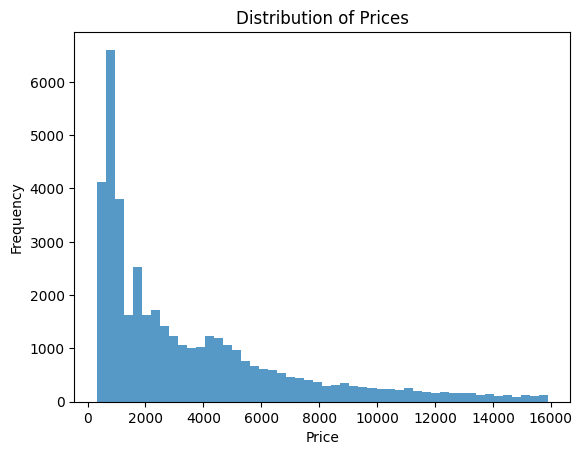

In [44]:
plt.hist(y_train, bins=50, alpha=0.75)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

It is clear that there exists right skewness. To handle it, we apply log transformation:

In [45]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

The log transformation reduces the effect of extreme values (outliers) in price, making the distribution more symmetric and suitable for training.

Let's check our `price` distribution now:

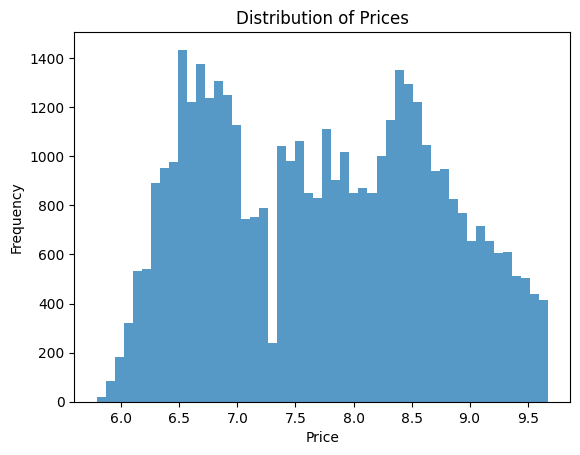

In [46]:
plt.hist(y_train, bins=50, alpha=0.75)
plt.title("Distribution of Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

By applying `log1p`, we preserved zeros in the dataset while reducing skewness.

### ***5. Training the Model:***

In [47]:
epochs = 10  # Number of epochs
batch_size = 128  # Batch size for mini-batch gradient descent

loss_history = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.fit(X_train, y_train, epochs=1, batch_size=batch_size)
    test_loss = model.evaluate(X_test, y_test)
    loss_history.append(test_loss)

Epoch 1/10
Epoch 1/1, Cost: 0.0938
Mean Squared Error: 0.0865
Epoch 2/10
Epoch 1/1, Cost: 0.0820
Mean Squared Error: 0.0764
Epoch 3/10
Epoch 1/1, Cost: 0.0747
Mean Squared Error: 0.0715
Epoch 4/10
Epoch 1/1, Cost: 0.0718
Mean Squared Error: 0.0700
Epoch 5/10
Epoch 1/1, Cost: 0.0709
Mean Squared Error: 0.0694
Epoch 6/10
Epoch 1/1, Cost: 0.0703
Mean Squared Error: 0.0688
Epoch 7/10
Epoch 1/1, Cost: 0.0700
Mean Squared Error: 0.0683
Epoch 8/10
Epoch 1/1, Cost: 0.0690
Mean Squared Error: 0.0671
Epoch 9/10
Epoch 1/1, Cost: 0.0669
Mean Squared Error: 0.0649
Epoch 10/10
Epoch 1/1, Cost: 0.0654
Mean Squared Error: 0.0640


In [48]:
baseline_prediction = np.mean(y_train)
baseline_mse = np.mean((y_train - baseline_prediction) ** 2)
print(f"Baseline MSE: {baseline_mse}")


Baseline MSE: 0.9555884685284534


Compared to the baseline MSE of **0.9556**, the model improved by over **93%**, validating its predictive accuracy.

### ***6. Loss Curve Visualization:***

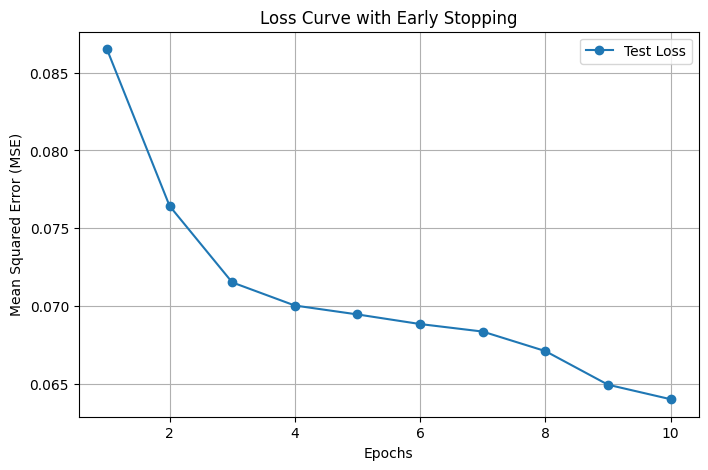

In [49]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label='Test Loss')
plt.title("Loss Curve with Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid()
plt.show()

### ***7. Residual Analysis:***

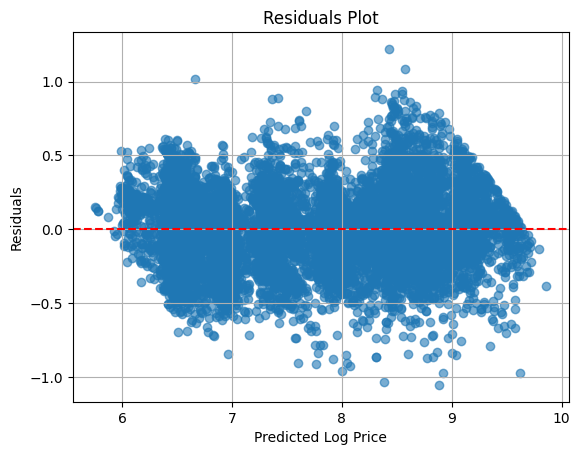

In [50]:
residuals = y_test.flatten() - model.predict(X_test).flatten()
plt.scatter(model.predict(X_test).flatten(), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Plot")
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.grid()
plt.show()

Since residuals are randomly distributed around zero, and there is no systematic patterns in the residuals, we can conclude that the model generalizes well.

### ***8. Predictions vs Actual:***

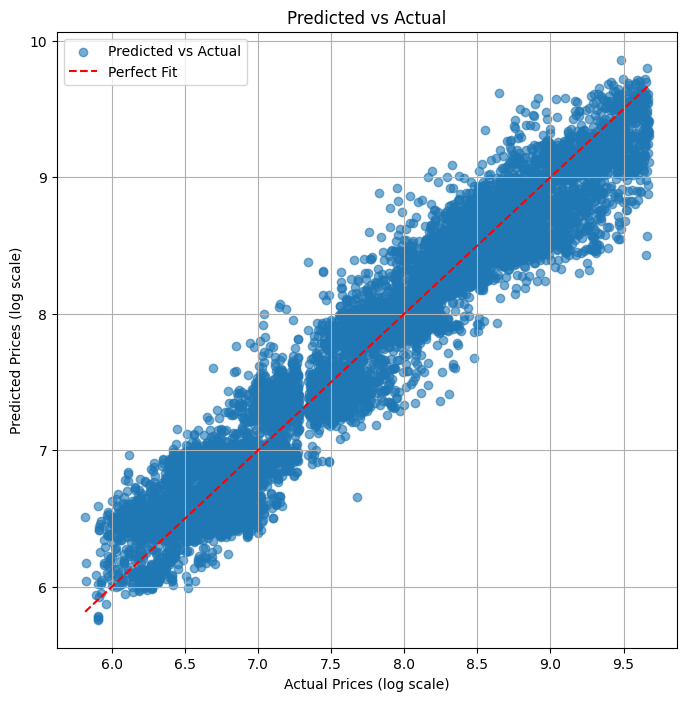

In [51]:
# Generate predictions
predictions = model.predict(X_test)

# Plot predictions vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.6, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.title("Predicted vs Actual")
plt.xlabel("Actual Prices (log scale)")
plt.ylabel("Predicted Prices (log scale)")
plt.legend()
plt.grid()
plt.show()


The scatter plot demonstrates strong alignment between predicted and actual values, with most points clustering around the diagonal (perfect fit).

### ***9. Save the Model:***

In [52]:
model.save_model('../models/diamond_price_predictor.npy')

Model saved to ../models/diamond_price_predictor.npy


### ***Conclusion:***

- The model effectively captures pricing trends based on `carat`, `x`, `y`, and `z`.

- Visualizations confirm the model's reliability and generalization.

- Achieving an MSE of **0.0640** highlights the model's accuracy, with performance far surpassing the baseline.